In [1]:
from IPython.display import display, HTML
display(HTML("""<style>.container { width:90% !important; }.text_cell_render, .output_text {font-family: Lato;font-size: 18px;line-height: 1.5;}.CodeMirror {font-size: 16px;}</style>"""))
from quiz.jupyterquiz import display_quiz

# Module 5

## Dataset

In PyTorch, a **dataset** is represented by a regular **Python class** that inherits from the [**Dataset**](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class. You can think of it as a kind of a Python **list of tuples**, each tuple corresponding to **one point (features, label)**.

The most fundamental methods it needs to implement are:

* **`__init__(self)`**: it takes **whatever arguments** needed to build a **list of tuples** — it may be the name of a CSV file that will be loaded and processed; it may be two tensors, one for features, another one for labels; or anything else, depending on the task at hand.

* **`__getitem__(self, index)`**: it allows the dataset to be **indexed**, so it can work like a list (`dataset[i]`) — it must **return a tuple (features, label)** corresponding to the requested data point. We can either return the **corresponding slices** of our **pre-loaded** dataset or tensors or, as mentioned above, **load them on demand** (like in this [example](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)).

* **`__len__(self)`**: it should simply return the **size** of the whole dataset so, whenever it is sampled, its indexing is limited to the actual size.

---

There is **no need to load the whole dataset in the constructor method** (`__init__`). If your **dataset is big** (tens of thousands of image files, for instance), loading it at once would not be memory efficient. It is recommended to **load them on demand** (whenever `__get_item__` is called).

---

Let’s build a simple custom dataset that takes two tensors as arguments: one for the features, one for the labels. For any given index, our dataset class will return the corresponding slice of each of those tensors. It should look like this:

In [119]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [120]:
# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


---

Did you notice we built our **training tensors** out of Numpy arrays but we **did not send them to a device**? So, they are **CPU** tensors now! **Why**?

We **don’t want our whole training data to be loaded into GPU tensors**, as we have been doing in our example so far, because **it takes up space** in our precious **graphics card’s RAM**.

---

### TensorDataset

Besides, you may be thinking “*why go through all this trouble to wrap a couple of tensors in a class?*”. And, once again, you do have a point… if a dataset is nothing else but a **couple of tensors**, we can use PyTorch’s [**TensorDataset**](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) class, which will do pretty much what we did in our custom dataset above.

In [121]:
from torch.utils.data import TensorDataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


OK, fine, but then again, **why** are we building a dataset anyway? We’re doing it because we want to use a…

## DataLoader, splitting your data into mini-batches

<h2><b><i>- Let's split data into mini-batches<br>- Use DataLoaders!</b></i></h2>

Until now, we have used the **whole training data** at every training step. It has been **batch gradient descent** all along. This is fine for our *ridiculously small dataset*, sure, but if we want to go serious about all this, we **must use mini-batch** gradient descent. Thus, we need mini-batches. Thus, we need to **slice** our dataset accordingly. 

Do you want to do it *manually*?! Me neither!

So we use PyTorch’s [**DataLoader**](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class for this job. We tell it which **dataset** to use (the one we just built in the previous section), the desired **mini-batch size** and if we’d like to **shuffle** it or not. That’s it!

---

There is more to a `+DataLoader+` than meets the eye—it is also possible to use it together with a **sampler** to fetch mini-batches that compensate for **imbalanced classes**, for instance. Too much to handle right now, but we will eventually get there.

---

Our **loader** will behave like an **iterator**, so we can **loop over it** and **fetch a different mini-batch** every time.

*Since PyTorch 1.7, in order to ensure reproducibility, we need to **assign a generator to the DataLoader**, so it is used in the corresponding sampler (provided it uses a generator, of course).*

In [122]:
from torch.utils.data import DataLoader

g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True, generator=g)

To retrieve a mini-batch, one can simply run the command below — it will return a list containing two tensors, one for the features, another one for the labels.

In [123]:
next(iter(train_loader))

[tensor([[0.3253],
         [0.9699],
         [0.1818],
         [0.7296],
         [0.7713],
         [0.3664],
         [0.9869],
         [0.2123],
         [0.3585],
         [0.0344],
         [0.5613],
         [0.7852],
         [0.0452],
         [0.0636],
         [0.0651],
         [0.3252]]),
 tensor([[1.8057],
         [2.9727],
         [1.3734],
         [2.5751],
         [2.4745],
         [1.7093],
         [3.0520],
         [1.4760],
         [1.7462],
         [1.1831],
         [2.0472],
         [2.5283],
         [0.9985],
         [1.1928],
         [1.1559],
         [1.7291]])]

How does this change our training loop? Let’s check it out!

In [124]:
#########################
## Model Configuration ##
#########################

lr = 1e-1

# Create a MODEL, a LOSS FUNCTION and an OPTIMIZER
model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

####################
## Model Training ##
####################

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

n_epochs = 1000

losses = []

for epoch in range(n_epochs):
    # inner loop
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step_fn(x_batch, y_batch)
        losses.append(loss)
        
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9661]], device='cuda:0')), ('0.bias', tensor([1.0178], device='cuda:0'))])


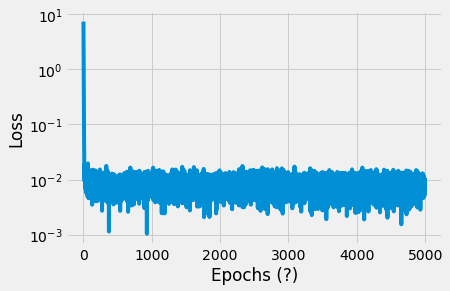

In [125]:
plt.plot(losses)
plt.xlabel('Epochs (?)')
plt.ylabel('Loss')
plt.yscale('log')

Did you notice it is taking **longer** to train now? Can you guess **why**?

Two things are different now: not only we have an **inner loop** to load each and every **mini-batch** from our **DataLoader** but, more importantly, we are now **sending only one mini-batch to the device**.

---

For bigger datasets, **loading data sample by sample** (into a **CPU** tensor) using **Dataset’s \__getitem__** and then **sending all samples** that belong to the **same mini-batch at once to your GPU** (device) is the way to go in order to make the **best use of your graphics card’s RAM**.

Moreover, if you have **many GPUs** to train your model on, it is best to keep your dataset “agnostic” and assign the batches to different GPUs during training.

---


So far, we’ve focused on the **training data** only. We built a *dataset* and a *data loader* for it. We could do the same for the **validation** data, using the **split** we performed at the beginning of this post… or we could use **random_split** instead.

### random_split

PyTorch’s [**random_split()**](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) method is an easy and familiar way of performing a **training-validation split**. Just keep in mind that, in our example, we need to apply it to the **whole dataset** (not the *training* dataset we built in couple of sections ago).

Then, for each subset of data, we build a corresponding DataLoader, so our code looks like this:

#### Data Preparation

In [129]:
from torch.utils.data.dataset import random_split

######################
## Data Preparation ##
######################

# builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# performs the split
train_dataset, val_dataset = random_split(dataset, [80, 20])

# builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

Now we have a **data loader** for our **validation** set, so, it makes sense to use it for the…

## Evaluation: does it generalize?

Now, we need to change the training loop to include the **evaluation of our model**, that is, computing the **validation loss**. The first step is to include another inner loop to handle the *mini-batches* that come from the *validation loader* , sending them to the same *device* as our model. Next, we make **predictions** using our model and compute the corresponding **loss**.

That’s pretty much it, but there are **two small, yet important**, things to consider:

* [**torch.no_grad()**](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad): even though it won’t make a difference in our simple model, it is a **good practice to wrap the validation inner loop with this context manager to disable any gradient calculation** that you may inadvertently trigger — **gradients belong in training**, not in validation steps;
    
* [**eval()**](https://bit.ly/3ge8X4H): the only thing it does is **setting the model to evaluation mode** (just like its `train()` counterpart did), so the model can adjust its behavior regarding some operations, like [**Dropout**](https://bit.ly/3346fuU).

So, we build a higher-order function that returns a **validation step function**:

In [134]:
def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval()
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step_fn

In [135]:
torch.manual_seed(42)

######################
## Data Preparation ##
######################

# builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# performs the split
train_dataset, val_dataset = random_split(dataset, [80, 20])

# builds a loader of each set
g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, generator=g)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

#########################
## Model Configuration ##
#########################

# defines learning rate
lr = 1e-1

# Create a MODEL, a LOSS FUNCTION and an OPTIMIZER
model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

####################
## Model Training ##
####################

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    mini_batch_losses = []
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_loss = train_step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        mini_batch_losses = []
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            mini_batch_loss = val_step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        val_loss = np.mean(mini_batch_losses)
        val_losses.append(val_loss) 

print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9570]], device='cuda:0')), ('0.bias', tensor([1.0085], device='cuda:0'))])


Now, our code should look like this:

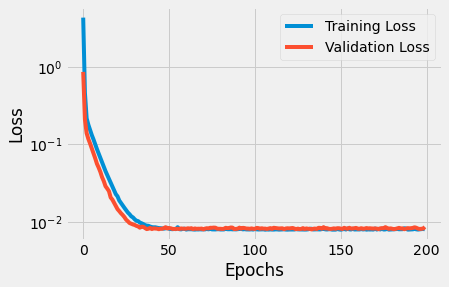

In [136]:
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

"*Wait, there is something weird with this plot...*", you say. You're right, the **validation loss** is **smaller** than the **training loss**. Shouldn't it be the other way around?! Well, generally speaking, *YES*, it should... but you can learn more about situations where this *swap* happens at this great [post](https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/).

## Saving (and Loading) Models: taking a break

<h2><b><i>"That would be great, to restart training later"</b></i></h2>

So, it is important to be able to **checkpoint** our model, in case we'd like to **restart training later**.

To checkpoint a model, we basically have to **save its state** into a file, to **load** it back later - nothing special, actually.

What defines the **state of a model**?
- **model.state_dict()**: kinda obvious, right?
- **optimizer.state_dict()**: remember optimizers had the `state_dict` as well?
- **loss**: after all, you should keep track of its evolution
- **epoch**: it is just a number, so why not? :-)
- **anything else you'd like to have restored**

Then, **wrap everything into a Python dictionary** and use [**torch.save()**](https://bit.ly/3jQOnJY) to dump it all into a file! Easy peasy!

In [108]:
checkpoint = {'epoch': n_epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': losses,
              'val_loss': val_losses}

torch.save(checkpoint, 'model_checkpoint.pth')

How would you **load** it back? Easy as well:
- load the dictionary back using [**torch.load()**](https://bit.ly/33jk9tp)
- load **model** and **optimizer** state dictionaries back using its methods [**load_state_dict()**](https://bit.ly/338dRwq)
- load everything else into their corresponding variables

In [109]:
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
losses = checkpoint['loss']
val_losses = checkpoint['val_loss']

You may save a model for **checkpointing**, like we have just done, or for **making predictions**, assuming training is finished.

After loading the model, **DO NOT FORGET**:

---

**SET THE MODE**:
- **checkpointing: model.train()**
- **predicting: model.eval()**

---

## Quiz

In [146]:
display_quiz('#./quiz/quiz5.b64')

## Exercise #5